In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import DataLoader
import torchvision.models as models
from scipy import linalg
import pandas as pd
from tqdm import tqdm


In [2]:
torch.manual_seed(1)
computing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Computing Device:', computing_device)
learning_rate = 0.0002
batch_size = 64
image_dim = 64
num_channels = 3  
noise_size = 100
total_epochs = 25
disc_features = 64 
gen_features = 64 
num_classes = 10
embedding_size = 100

Computing Device: cuda


In [3]:
dataset = datasets.CIFAR10(root="./dataset/CIFAR10_data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_dim),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

data_loader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


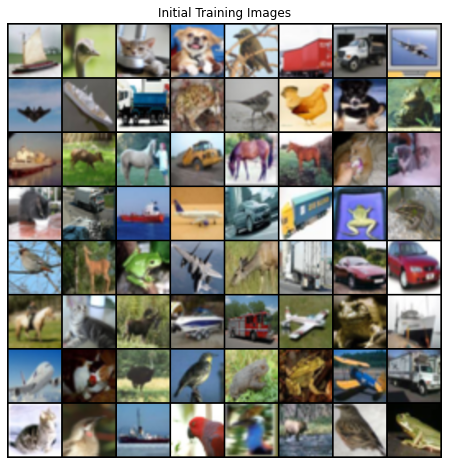

In [4]:
initial_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Initial Training Images")
plt.imshow(np.transpose(utils.make_grid(initial_batch[0].to(computing_device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
def set_weights(module):
    for element in module.modules():
        if isinstance(element, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(element.weight.data, 0.0, 0.02)

In [6]:
class Generator(nn.Module):
    def __init__(self, classes_count, img_dim, embedding_dim, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.img_dim = img_dim
        self.net = nn.Sequential(
            nn.ConvTranspose2d(noise_size + embedding_dim, features_g * 16, 4, 1, 0, bias=False),
            self.gen_block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self.gen_block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self.gen_block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )
        self.embed = nn.Embedding(classes_count, embedding_dim)

    def gen_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.net(x)

generator = Generator(num_classes, image_dim, embedding_size, noise_size, num_channels, gen_features).to(computing_device)
set_weights(generator)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, classes_count, img_dim, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self.disc_block(features_d, features_d * 2, 4, 2, 1),
            self.disc_block(features_d * 2, features_d * 4, 4, 2, 1),
            self.disc_block(features_d * 4, features_d * 8, 4, 2, 1),
        )
        self.validity_layer = nn.Sequential(
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
        self.labels_layer = nn.Sequential(
            nn.Conv2d(512, 11, 4, 1, 0, bias=False),
            nn.LogSoftmax(dim=1)
        )
        self.embed = nn.Embedding(classes_count, img_dim * img_dim)

    def disc_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.disc(x)
        valid = self.validity_layer(x).view(-1)
        label = self.labels_layer(x).view(-1, 11)
        return valid, label

discriminator = Discriminator(num_classes, image_dim, num_channels, disc_features).to(computing_device)
set_weights(discriminator)

generator.train(), discriminator.train()

(Generator(
   (net): Sequential(
     (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (5): Tanh()
   )
   (embed): Embedding(10, 100)
 ),
 Discriminato

In [8]:
class InceptionV3(nn.Module):
    
    
    DEFAULT_BLOCK_INDEX = 3

    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling features
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model_inception = InceptionV3([block_idx])
model_inception = model_inception.cuda()

/home/jkoduri/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jkoduri/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
def calc_activation_stats(images, model, batch_size=128, dims=2048, use_cuda=False):
    model.eval()
    activations = np.empty((len(images), dims))
    
    if use_cuda:
        batch = images.cuda()
    else:
        batch = images
    predictions = model(batch)[0]

    if predictions.size(2) != 1 or predictions.size(3) != 1:
        predictions = adaptive_avg_pool2d(predictions, output_size=(1, 1))

    activations = predictions.cpu().data.numpy().reshape(predictions.size(0), -1)
    
    mean_act = np.mean(activations, axis=0)
    cov_act = np.cov(activations, rowvar=False)
    return mean_act, cov_act

def calc_frechet_distance(mu1, sigma1, mu2, sigma2, epsilon=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % epsilon
        print(msg)
        offset = np.eye(sigma1.shape[0]) * epsilon
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fid(real_images, fake_images, model):
    mu_real, sigma_real = calc_activation_stats(real_images, model, use_cuda=True)
    mu_fake, sigma_fake = calc_activation_stats(fake_images, model, use_cuda=True)
    
    fid_score = calc_frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake)
    return fid_score


fixed_noise = torch.randn(32, noise_size, 1, 1).to(computing_device)
iteration_count = 0

optim_discriminator = optim.Adam(discriminator.parameters(), learning_rate, betas=(0.5, 0.999))
optim_generator = optim.Adam(generator.parameters(), learning_rate, betas=(0.5, 0.999))
loss_function = nn.BCELoss()

# Tracking metrics
generator_losses = []
discriminator_losses = []
image_history = []
iterations = 0
fid_scores = []

print("!!Training Commenced!!")

!!Training Commenced!!


In [11]:
start_time = time.time() 
current_epoch = 0
while current_epoch < total_epochs:
    current_epoch += 1
    for batch_idx, (actual_images, actual_labels) in tqdm(enumerate(data_loader)):
        real_images = actual_images.to(computing_device)
        labels = actual_labels.to(computing_device)
        batch_current = real_images.shape[0]
        
        fake_class_labels = 10 * torch.ones((batch_current,), dtype=torch.long).to(computing_device)        
        discriminator.zero_grad()

        real_labels = torch.full((batch_current,), 1.0, dtype=torch.float).to(computing_device)
        disc_real_output, disc_labels_output = discriminator(real_images)
        loss_disc_real = loss_function(disc_real_output, real_labels)
        disc_real_label_loss = F.nll_loss(disc_labels_output, labels) 
        real_disc_loss = loss_disc_real + disc_real_label_loss
        real_disc_loss.backward()

        sample_labels = torch.randint(0, 10, (batch_current,), dtype=torch.long).to(computing_device)
        noise = torch.randn(batch_current, noise_size, 1, 1).to(computing_device)
        fake_images = generator(noise, sample_labels) 
        disc_fake_output, disc_fake_labels = discriminator(fake_images.detach())
        real_labels.fill_(0.0)
        loss_disc_fake = loss_function(disc_fake_output, real_labels)
        disc_fake_label_loss = F.nll_loss(disc_fake_labels, fake_class_labels) 
        fake_disc_loss = loss_disc_fake + disc_fake_label_loss
        fake_disc_loss.backward()
    
        total_disc_loss = (real_disc_loss + fake_disc_loss) / 2
        optim_discriminator.step()

        generator.zero_grad()
        noise = torch.randn(batch_current, noise_size, 1, 1).to(computing_device)
        sample_labels = torch.randint(0, 10, (batch_current,), dtype=torch.long).to(computing_device)
        real_labels.fill_(1.0)
        fake_images = generator(noise, sample_labels)
        gen_output, gen_labels_output = discriminator(fake_images)

        loss_gen_real = loss_function(gen_output, real_labels)
        gen_label_loss = F.nll_loss(gen_labels_output, sample_labels)
        total_gen_loss = loss_gen_real + gen_label_loss
        total_gen_loss.backward()
        optim_generator.step()
        

        generator_losses.append(total_gen_loss.detach().cpu())
        discriminator_losses.append(total_disc_loss.detach().cpu())
        
        
    with torch.no_grad():
        fake_images = generator(noise, sample_labels).detach().cpu()
    image_history.append(utils.make_grid(fake_images, padding=2, normalize=True))
    
    fid_value = calculate_fid(real_images, fake_images, model_inception)
    fid_scores.append(fid_value)

    print(f"Epoch [{current_epoch}/{total_epochs}]  \
      Loss Discriminator: {total_disc_loss:.3f}, Loss Generator: {total_gen_loss:.3f}, FID Score: {fid_value:.3f}")         
    
end_time = time.time()
print('\n\n Elapsed Time: %.2f s.' % (end_time - start_time))

782it [00:47, 16.37it/s]


Epoch [1/25]        Loss Discriminator: 2.107, Loss Generator: 2.935, FID Score: 410.257


782it [00:45, 17.24it/s]


Epoch [2/25]        Loss Discriminator: 2.045, Loss Generator: 2.130, FID Score: 367.215


782it [00:45, 17.29it/s]


Epoch [3/25]        Loss Discriminator: 1.993, Loss Generator: 3.611, FID Score: 377.918


782it [00:45, 17.19it/s]


Epoch [4/25]        Loss Discriminator: 1.575, Loss Generator: 3.291, FID Score: 380.772


782it [00:45, 17.27it/s]


Epoch [5/25]        Loss Discriminator: 1.762, Loss Generator: 4.438, FID Score: 404.773


782it [00:45, 17.21it/s]


Epoch [6/25]        Loss Discriminator: 2.510, Loss Generator: 3.961, FID Score: 340.231


782it [00:45, 17.21it/s]


Epoch [7/25]        Loss Discriminator: 1.500, Loss Generator: 6.630, FID Score: 340.448


782it [00:45, 17.19it/s]


Epoch [8/25]        Loss Discriminator: 1.121, Loss Generator: 5.785, FID Score: 293.872


782it [00:45, 17.17it/s]


Epoch [9/25]        Loss Discriminator: 1.323, Loss Generator: 10.044, FID Score: 319.300


782it [00:45, 17.17it/s]


Epoch [10/25]        Loss Discriminator: 0.899, Loss Generator: 8.454, FID Score: 312.703


782it [00:45, 17.20it/s]


Epoch [11/25]        Loss Discriminator: 1.238, Loss Generator: 5.715, FID Score: 341.093


782it [00:45, 17.22it/s]


Epoch [12/25]        Loss Discriminator: 0.832, Loss Generator: 5.543, FID Score: 351.569


782it [00:45, 17.20it/s]


Epoch [13/25]        Loss Discriminator: 0.917, Loss Generator: 6.222, FID Score: 311.583


782it [00:45, 17.20it/s]


Epoch [14/25]        Loss Discriminator: 0.851, Loss Generator: 7.507, FID Score: 288.889


782it [00:45, 17.23it/s]


Epoch [15/25]        Loss Discriminator: 0.938, Loss Generator: 7.829, FID Score: 323.428


782it [00:45, 17.25it/s]


Epoch [16/25]        Loss Discriminator: 1.041, Loss Generator: 6.596, FID Score: 309.288


782it [00:45, 17.12it/s]


Epoch [17/25]        Loss Discriminator: 0.876, Loss Generator: 10.114, FID Score: 257.393


782it [00:45, 17.22it/s]


Epoch [18/25]        Loss Discriminator: 1.494, Loss Generator: 10.515, FID Score: 282.886


782it [00:45, 17.10it/s]


Epoch [19/25]        Loss Discriminator: 4.117, Loss Generator: 11.363, FID Score: 310.640


782it [00:45, 17.10it/s]


Epoch [20/25]        Loss Discriminator: 0.809, Loss Generator: 12.647, FID Score: 289.713


782it [00:45, 17.18it/s]


Epoch [21/25]        Loss Discriminator: 0.852, Loss Generator: 7.349, FID Score: 305.670


782it [00:45, 17.21it/s]


Epoch [22/25]        Loss Discriminator: 0.863, Loss Generator: 9.446, FID Score: 297.656


782it [00:45, 17.21it/s]


Epoch [23/25]        Loss Discriminator: 0.594, Loss Generator: 5.860, FID Score: 335.916


782it [00:45, 17.20it/s]


Epoch [24/25]        Loss Discriminator: 0.799, Loss Generator: 7.829, FID Score: 315.300


782it [00:45, 17.25it/s]


Epoch [25/25]        Loss Discriminator: 0.980, Loss Generator: 6.524, FID Score: 333.334


 Elapsed Time: 1244.15 s.


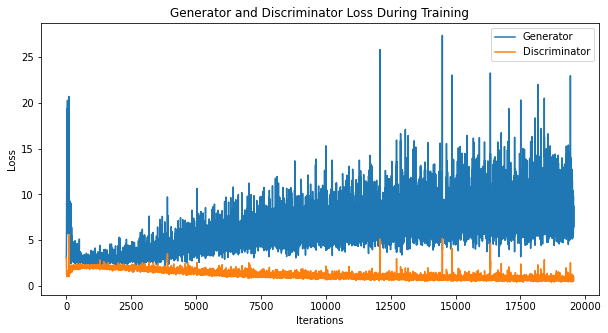

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses, label="Generator")
plt.plot(discriminator_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

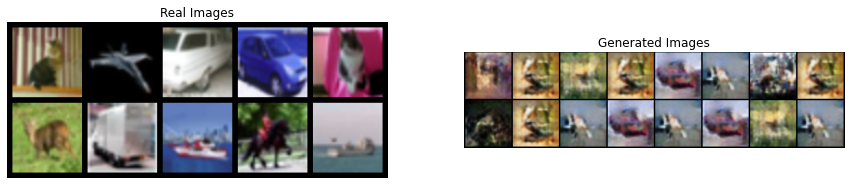

In [13]:
new_batch = next(iter(data_loader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(new_batch[0].to(computing_device)[:10], nrow=5, padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(image_history[-1],(1,2,0)))
plt.show()

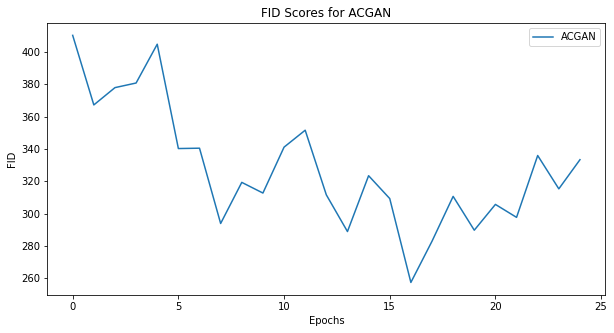

In [14]:
plt.figure(figsize=(10,5))
plt.title("FID Scores for ACGAN")
plt.plot(fid_scores, label="ACGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.show()

In [15]:
np.mean(fid_scores), fid_scores[-5]

(328.0739083954671, 305.67024886427015)